# Model Vs. Simple Historical Recommndations 

This is to go a step ahead of simply saying that our model has a good RMSE score, which can be easy for a model that is based on such auto regressive features. This is to show that our model provides more value than simply recommending zip codes that previously had large growth (we defined large growth as avergaing growth over 4%). We did this by comparing those zip codes that historically had strong growth to zip codes that our model suggested would have large growth in the future. Our model does tend to suggest zip codes with larger growth than the historical only (naive) approach.

In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.patches as mpatches
import helper

from sklearn.preprocessing import StandardScaler
# loading custom style
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### prepping for mapping

In [2]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)

# lists of relevent zipcodes
target_zips = pd.read_csv('target.csv', index_col = 0)
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())
# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}


#### Loading and processing data to put into model. And Construct model.

In [3]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# Merge and lag data to be ready to forecast a year in the future
merged_df = helper.zri_data_pipeline(zri, texas_data, acs_data)

# Split dataframe into train, test, and forecast,
train, test, forecast = helper.train_test_forecast_split(
    merged_df,
    train_date = datetime.datetime(2020,7,2), 
    forecast_date = datetime.datetime(2021,7,2)
)

# define features to be put into the model and target variable.

X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    ]
y_val = 'zori_ssa'

# Shrink data to features to be put into the model
# and scale data to prepare it to be put into the model
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

# construct model
clf = helper.lasso_gridCV_fit(X, y)

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


####  Feeding forecast values into model

In [4]:
# y_pred_fore = clf.predict(X_forecast)
# forecast.loc[:,'pred'] = y_pred_fore

#### Construct timeline of zori and what prediciton status they are.

In [5]:
# find predicted and actual annual percent rent growth
y_pred_test = clf.predict(X_test)
test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']

# average that growth across all 12 months for each zipcode
pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_act_growth=('actual_12_month_growth_per', 'mean'),
    std_act_growth=('actual_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

# make list of zip codes the model thinks will grow an average of 4%
model_rec_zips = pred_growth[pred_growth['mean_pred_growth']>.04].zip_code.to_list()
# make a list of zip codes that averaged a 4% growth in the past year.
naive_rec_zips = pred_growth[pred_growth['mean_naive_growth']>.04].zip_code.to_list()

In [6]:
# define each zipcode zipcode based on if model and/or naive approach recommends the zipcode
pred_growth.loc[:,'invest_rec'] = 0
pred_growth.loc[pred_growth['zip_code'].isin(model_rec_zips),'invest_rec'] = 3
pred_growth.loc[pred_growth['zip_code'].isin(naive_rec_zips),'invest_rec'] = 1
pred_growth.loc[(pred_growth['zip_code'].isin(naive_rec_zips) &
          pred_growth['zip_code'].isin(model_rec_zips))
          ,'invest_rec'] = 2

#### graph test period recommendations

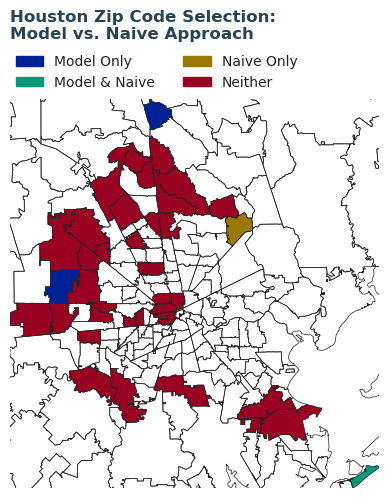

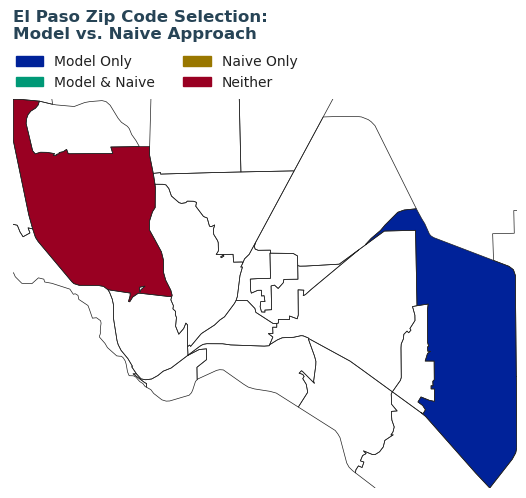

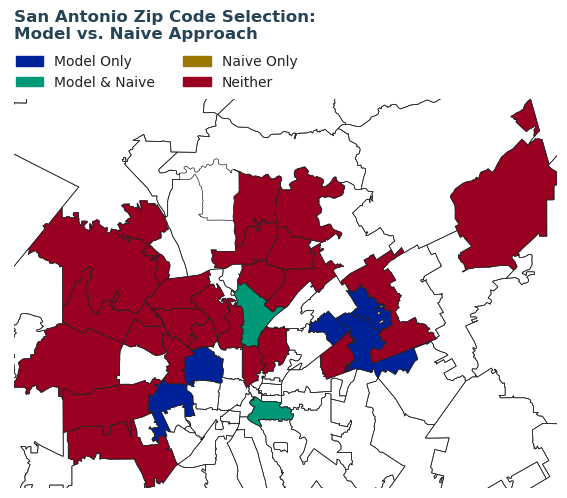

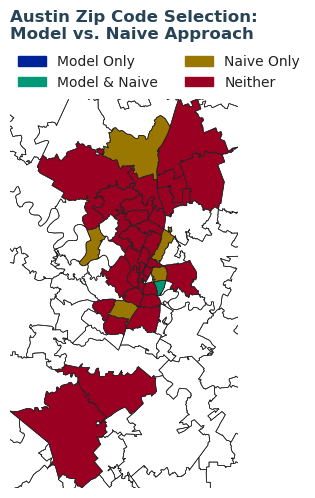

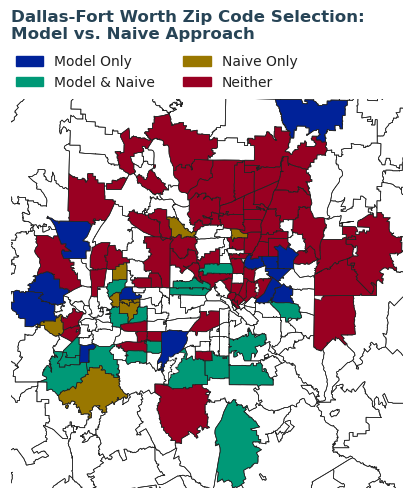

In [7]:
# match colors to correct groups
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = pred_growth
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    # merge invest_rec column into geopandas dataframe to graph on a map.
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    # boundry map of all nearby texas zip codes
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    # construct map. 
    graph_df.plot(ax=zip_boundry_map, 
                  color=graph_df["invest_rec"].map(color_mapping),
                  legend=True,
                    )
    # turn off axis grid
    zip_boundry_map.axis('off')
    # zoom graph into only spaces we have relevant zipcodes mapped
    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    # title
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    model_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    model_naive_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    naive_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    neither_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[model_patch, model_naive_patch, naive_patch,neither_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

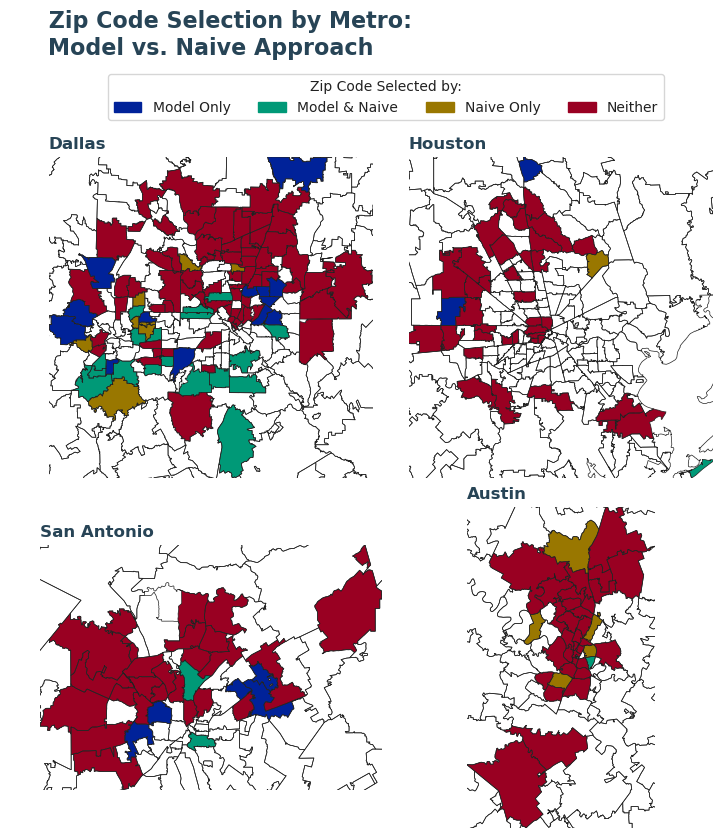

In [8]:
# match colors to correct groups
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = pred_growth

fig, axs = plt.subplots(2,2, constrained_layout=True,
                       figsize=(7,7))
## Dallas
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = dallas_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
              color=graph_df["invest_rec"].map(color_mapping),
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,0].set_xlim(minx, maxx)
axs[0,0].set_ylim(miny, maxy)
# plot title
axs[0,0].set(xlabel='', ylabel='',title="Dallas")

## austin_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = austin_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
              color=graph_df["invest_rec"].map(color_mapping),
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,1].set_xlim(minx, maxx)
axs[1,1].set_ylim(miny, maxy)
# plot title
axs[1,1].set(xlabel='', ylabel='',title="Austin")

## san_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = san_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
              color=graph_df["invest_rec"].map(color_mapping),
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,0].set_xlim(minx, maxx)
axs[1,0].set_ylim(miny, maxy)
# plot title
axs[1,0].set(xlabel='', ylabel='',title="San Antonio")

## houston_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = houston_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
              color=graph_df["invest_rec"].map(color_mapping),
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,1].set_xlim(minx, maxx)
axs[0,1].set_ylim(miny, maxy)
# plot title
axs[0,1].set(xlabel='', ylabel='',title='Houston')

fig.suptitle('     Zip Code Selection by Metro:\nModel vs. Naive Approach', fontsize=16, x = .25, y = 1.175,
             color = '#274456', weight = 'bold')

# # legend
model_patch = mpatches.Patch(color=four_colors[3], 
                           label='Model Only')
model_naive_patch = mpatches.Patch(color=four_colors[2], 
                           label='Model & Naive')
naive_patch = mpatches.Patch(color=four_colors[1], 
                           label='Naive Only')
neither_patch = mpatches.Patch(color=four_colors[0], 
                           label='Neither')
fig.legend(handles=[model_patch, model_naive_patch, naive_patch,neither_patch],
           loc='center', 
           bbox_to_anchor=(0.5, 1.05),frameon=True,ncol=4,
                title = 'Zip Code Selected by:')
plt.show()

### Model Errors

#### Model errors by recommendation type

<ipython-input-9-7dbe8ce23418>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])


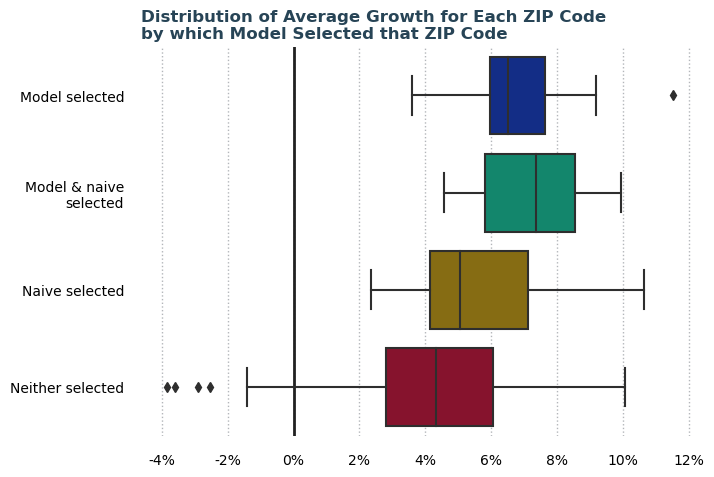

In [9]:
graph_df = pred_growth
fig, ax = plt.subplots()
# graph boxplots
g = sns.boxplot(data = graph_df, y = 'invest_rec',
                x = 'mean_act_growth', palette = four_colors[::-1],
                orient = 'h',ax = ax, order = [3,2,1,0]
                )

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

# # set labels
g.set_yticklabels(labels = [
    'Model selected', 'Model & naive\nselected', 
    'Naive selected', 'Neither selected'
])

# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Average Growth for Each ZIP Code'+
      ' \nby which Model Selected that ZIP Code')

# # adding a vertical line at 0 percent growth
plt.axvline(0, color = '#212121', zorder = .7, linewidth = 2)

# add percent x tick labels
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])

# remove x axis grid lines that were cluttering the graph
# i know i'm repeating this line but if i don't do it twice it doesn't work. ?!
ax.grid(b = None, axis = 'y')

plt.show()

#### Model errors zip code

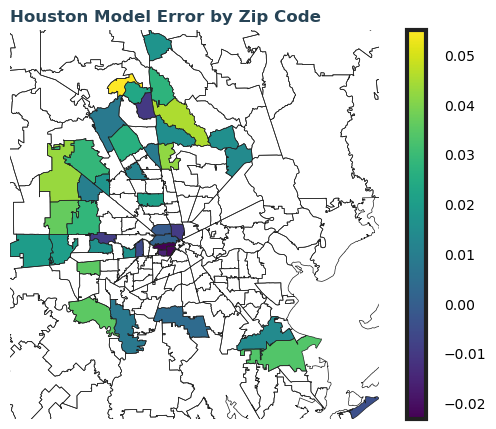

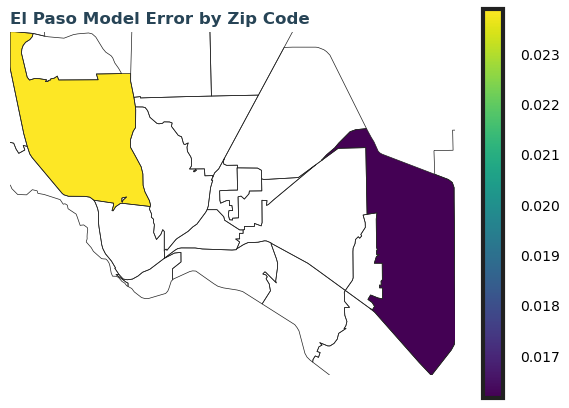

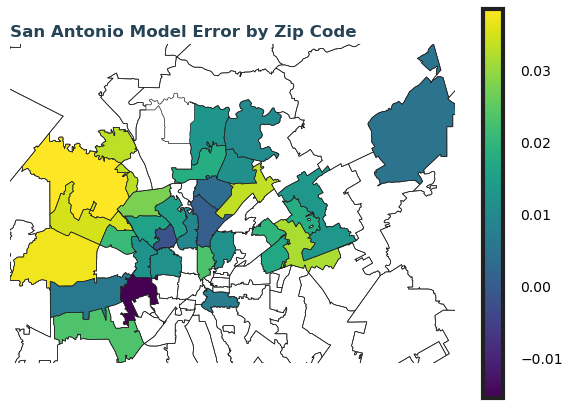

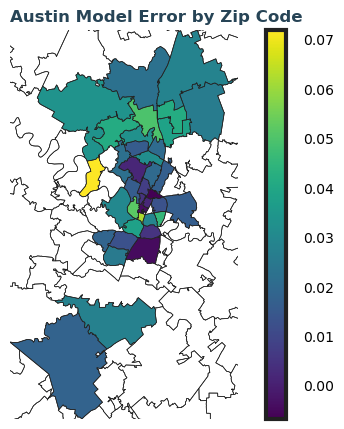

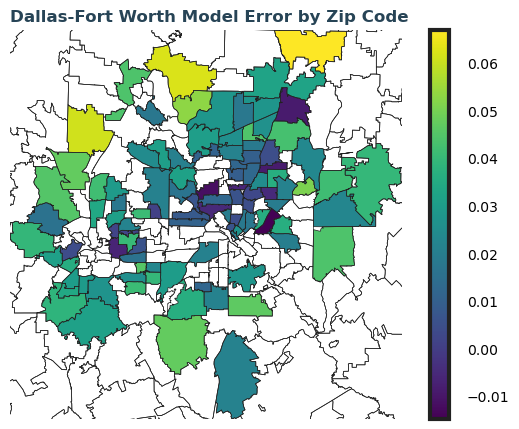

In [10]:
# setting up data to graph
pred_errors = test.groupby('zip_code').agg({'pred_difference_per':'mean'}).reset_index()
map_ = pred_errors
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    # merge pred_difference_per column into geopandas dataframe to graph on a map.
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    # set up all zip code boundrys
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    # graph errors
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
                  legend=True,
                    )
    # turn off axis grid lines
    zip_boundry_map.axis('off')
    # zoom graph into only spaces we have relevant zipcodes mapped
    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    # title
    plt.title(metro +' Model Error by Zip Code')
    plt.show()

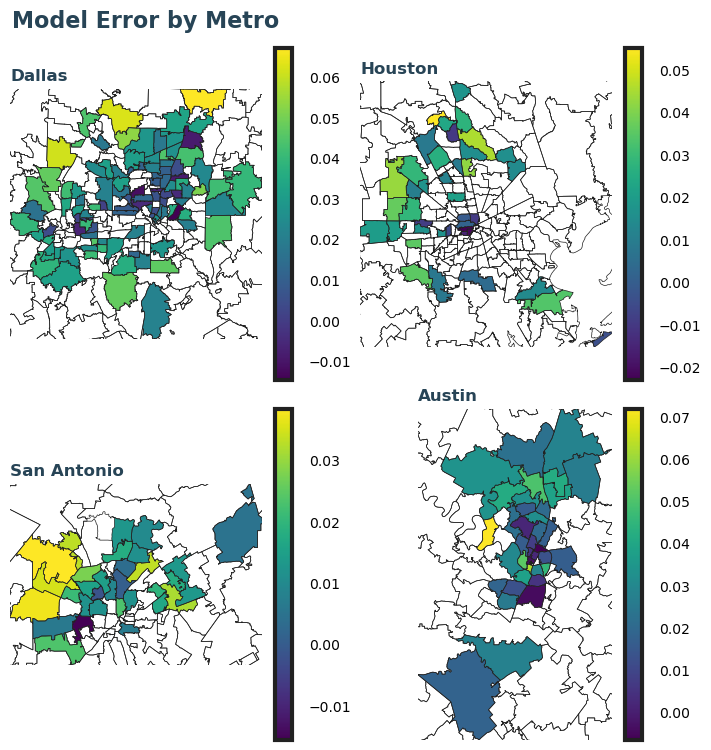

In [11]:
# setting up data to graph
pred_errors = test.groupby('zip_code').agg({'pred_difference_per':'mean'}).reset_index()
map_ = pred_errors

fig, axs = plt.subplots(2,2, constrained_layout=True,
                       figsize=(7,7))
## Dallas
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = dallas_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["pred_difference_per"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,0].set_xlim(minx, maxx)
axs[0,0].set_ylim(miny, maxy)
# plot title
axs[0,0].set(xlabel='', ylabel='',title="Dallas")

## austin_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = austin_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["pred_difference_per"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,1].set_xlim(minx, maxx)
axs[1,1].set_ylim(miny, maxy)
# plot title
axs[1,1].set(xlabel='', ylabel='',title="Austin")

## san_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = san_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["pred_difference_per"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,0].set_xlim(minx, maxx)
axs[1,0].set_ylim(miny, maxy)
# plot title
axs[1,0].set(xlabel='', ylabel='',title="San Antonio")

## houston_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = houston_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["pred_difference_per"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,1].set_xlim(minx, maxx)
axs[0,1].set_ylim(miny, maxy)
# plot title
axs[0,1].set(xlabel='', ylabel='',title='Houston')

fig.suptitle('Model Error by Metro', fontsize=16, x = 0.2, y = 1.05,
             color = '#274456', weight = 'bold')

plt.show()

## forecasted recommendations

In [12]:
# find forecasted annual percent rent growth
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore

forecast['pred_12_month_growth'] = forecast['pred'] - forecast['zori_ssa_12_month_shift']
forecast['pred_12_month_growth_per'] = forecast['pred_12_month_growth']/forecast['zori_ssa_12_month_shift']

# average that growth across all 12 months for each zipcode
fore_pred_growth = forecast.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

# make list of zip codes the model thinks will grow an average of 4%
fore_model_rec_zips = fore_pred_growth[fore_pred_growth['mean_pred_growth']>.04].zip_code.to_list()
# make a list of zip codes that averaged a 4% growth in the past year.
fore_naive_rec_zips = fore_pred_growth[fore_pred_growth['mean_naive_growth']>.04].zip_code.to_list()

In [13]:
# define each zipcode zipcode based on if model and/or naive approach recommends the zipcode
fore_pred_growth.loc[:,'invest_rec'] = 0
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_model_rec_zips),'invest_rec'] = 3
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_naive_rec_zips),'invest_rec'] = 1
fore_pred_growth.loc[(fore_pred_growth['zip_code'].isin(fore_naive_rec_zips) &
          fore_pred_growth['zip_code'].isin(fore_model_rec_zips))
          ,'invest_rec'] = 2

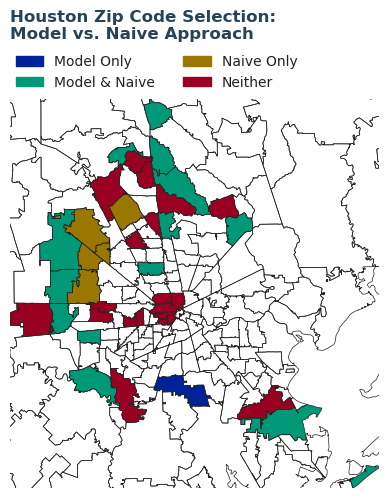

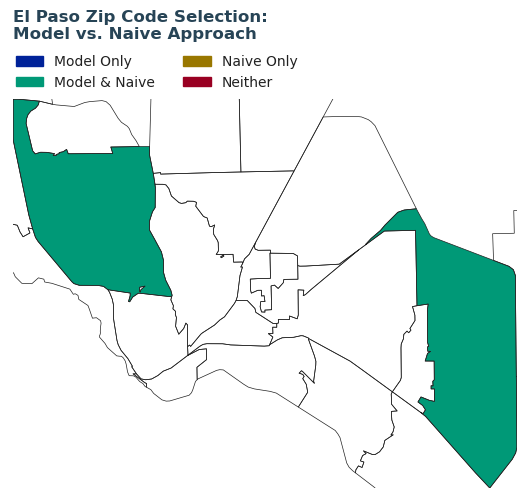

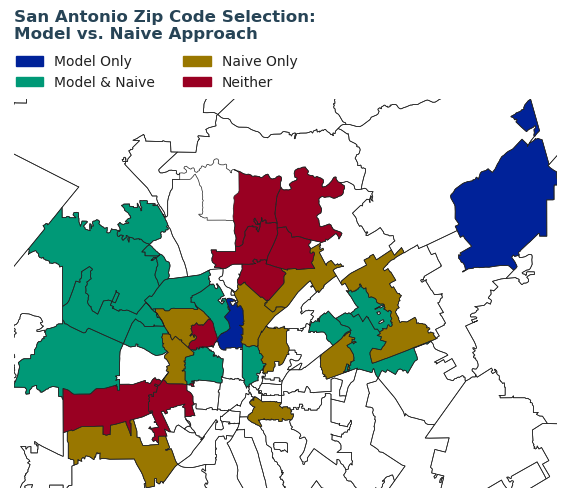

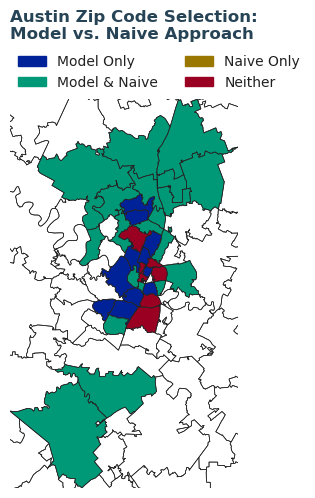

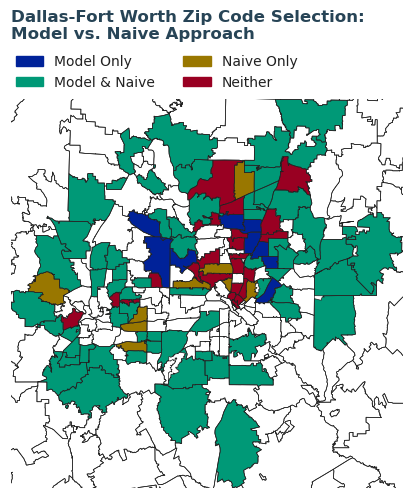

In [14]:
# match colors to correct groups
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = fore_pred_growth
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    # merge invest_rec column into geopandas dataframe to graph on a map.
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    # boundry map of all nearby texas zip codes
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    # construct map. 
    graph_df.plot(ax=zip_boundry_map, 
                  color=graph_df["invest_rec"].map(color_mapping),
                  legend=True,
                    )
    # turn off axis grid
    zip_boundry_map.axis('off')
    # zoom graph into only spaces we have relevant zipcodes mapped
    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    # title
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    model_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    model_naive_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    naive_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    neither_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[model_patch, model_naive_patch, naive_patch,neither_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

#### Forecasted growth

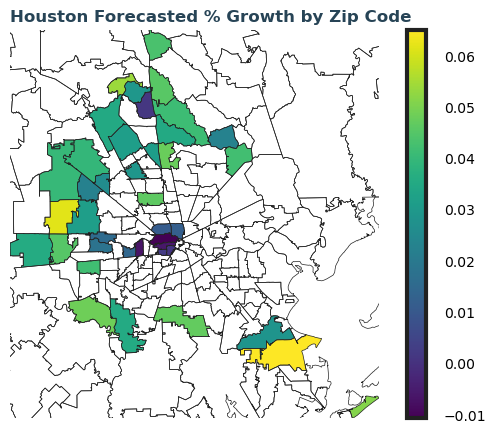

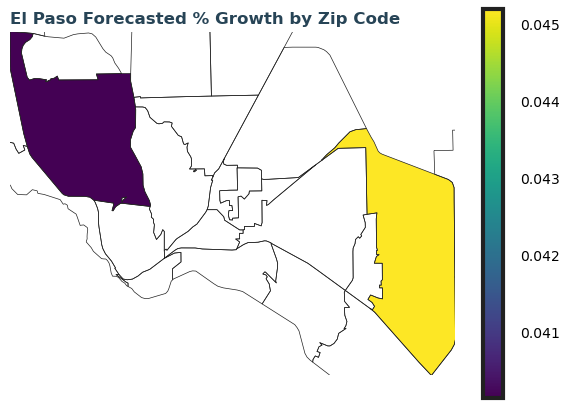

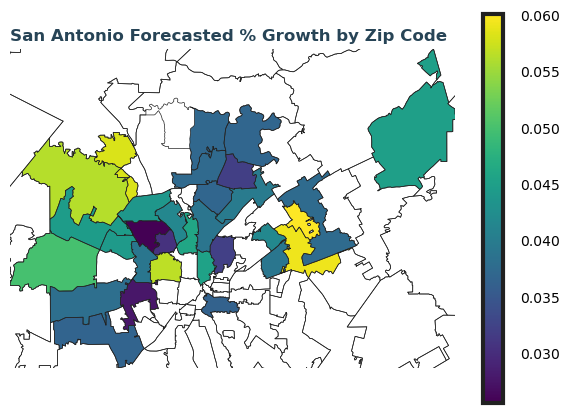

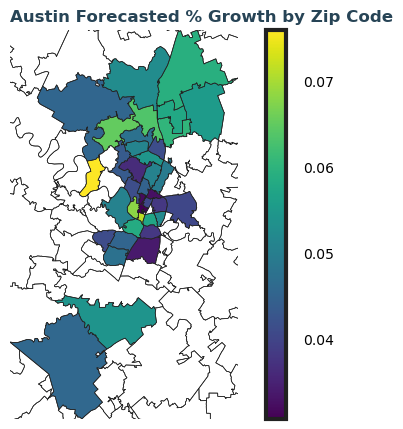

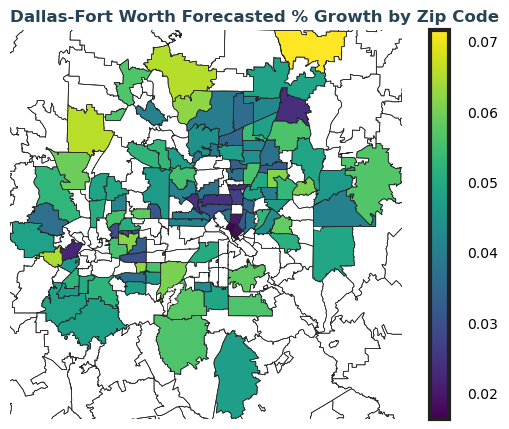

In [15]:
map_ = fore_pred_growth
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}
    
# looping the graphing to make sure it works
for metro in different_metros.keys():
    # merge mean_pred_growth column into geopandas dataframe to graph on a map.
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    # set up all zip code boundrys
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    # graph errors
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["mean_pred_growth"], 
                  legend=True,
                    )
    # turn off axis grid lines
    zip_boundry_map.axis('off')
    # zoom graph into only spaces we have relevant zipcodes mapped
    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    # title
    plt.title(metro +' Forecasted % Growth by Zip Code')
    plt.show()

In [ ]:
# setting up data to graph
map_ = fore_pred_growth

fig, axs = plt.subplots(2,2, constrained_layout=True,
                       figsize=(7,7))
## Dallas
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = dallas_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["mean_pred_growth"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,0].set_xlim(minx, maxx)
axs[0,0].set_ylim(miny, maxy)
# plot title
axs[0,0].set(xlabel='', ylabel='',title="Dallas")

## austin_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = austin_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["mean_pred_growth"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,1].set_xlim(minx, maxx)
axs[1,1].set_ylim(miny, maxy)
# plot title
axs[1,1].set(xlabel='', ylabel='',title="Austin")

## san_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = san_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[1,0])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["mean_pred_growth"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[1,0].set_xlim(minx, maxx)
axs[1,0].set_ylim(miny, maxy)
# plot title
axs[1,0].set(xlabel='', ylabel='',title="San Antonio")

## houston_zips
# merge invest_rec column into geopandas dataframe to graph on a map.
graph_df = houston_zips.merge(map_, right_on='zip_code' ,left_on='GEOID10')
# boundry map of all nearby texas zip codes
zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=axs[0,1])
# construct map. 
graph_df.plot(ax=zip_boundry_map, 
             column = graph_df["mean_pred_growth"], 
              legend=True,
                )
# turn off axis grid
zip_boundry_map.axis('off')
# zoom graph into only spaces we have relevant zipcodes mapped
minx, miny, maxx, maxy = graph_df.total_bounds
axs[0,1].set_xlim(minx, maxx)
axs[0,1].set_ylim(miny, maxy)
# plot title
axs[0,1].set(xlabel='', ylabel='',title='Houston')

fig.suptitle('Forecasted % Growth by Metro', fontsize=16, x = 0.2, y = 1.05,
             color = '#274456', weight = 'bold')

plt.show()